# General processing of flight data

In [208]:
from aux.gpx_read import *
from aux.imu_read import *
from aux.lidar_read import *
from aux.navsat_read import *
from aux.px4_read import *
from aux.rosbag_aux import *
from aux.srr308_read import *

import datetime

test_num = 2
test_names = ['6m_1', '6m_2', '50m_1', '50m_2', '80m_1', '80m_2']
name = test_names[test_num]
folder_path = 'data/' + name
db3_reader = get_db3_reader(folder_path, 'ROSBAG*')
db3_px4_reader = get_db3_reader(folder_path, 'sensor_bag*')

# create all data frames to find the first timestamp to reference every other DF to
vel_df = get_velocity_df_from_db3_reader(db3_reader)
baro_df = get_baro_df_from_db3_reader(db3_px4_reader)
gyro_df = get_gyro_df_from_db3_reader(db3_px4_reader)
acc_df = get_acc_df_from_db3_reader(db3_px4_reader)
imu_df = get_imu_df_from_db3_reader(db3_px4_reader)
sc_df = get_sensor_combined_df_from_db3_reader(db3_px4_reader)

df_list = [vel_df, baro_df, gyro_df, acc_df, imu_df, sc_df]
first_timestamp = vel_df['timestamp_sample'][0]
for df in df_list:
    first_timestamp = min(first_timestamp, df['timestamp_sample'][0])

print("First time stamp:", datetime.datetime.fromtimestamp(first_timestamp).isoformat())

Found ROS 2 bag: data/50m_1/ROSBAG_2025-04-28_12-21-24.378/ROSBAG_2025-04-28_12-21-24.378_0.db3
Found ROS 2 bag: data/50m_1/sensor_bag_20250428_122123/sensor_bag_20250428_122123_0.db3


[INFO] [1746444839.950382780] [rosbag2_storage]: Opened database 'data/50m_1/ROSBAG_2025-04-28_12-21-24.378/ROSBAG_2025-04-28_12-21-24.378_0.db3' for READ_ONLY.
[INFO] [1746444840.297794302] [rosbag2_storage]: Opened database 'data/50m_1/sensor_bag_20250428_122123/sensor_bag_20250428_122123_0.db3' for READ_ONLY.


First time stamp: 2025-04-28T12:21:24.512461


### Where and when do the static parts of the experiment take place?

In [209]:
def get_segment_index_from_ts_segments(sensor_df, reference_ts_segments):
    sensor_segments = []
    m = 0   # to comare to
    _s = -1
    _e = -1
    for i in range(sensor_df.shape[0]):
        if (m < len(reference_ts_segments)):
            ts_seg = reference_ts_segments[m]
            ts = sensor_df['timestamp_sample'][i]
            if (ts >= ts_seg[0] and _s == -1):  # first time current ts is above the lower limit
                _s = i
            if (ts <= ts_seg[1]):
                _e = i
            if (ts > ts_seg[1]):
                if (_e > _s):
                    sensor_segments.append([_s, _e])
                _s, _e = -1, -1
                m += 1
    if (_s != -1): # segment initialized but not finalized
        sensor_segments.append([_s, sensor_df.shape[0]-1])
    return sensor_segments

def get_sensor_flight_seconds(sensor_df, first_ts):
    return [sensor_df['timestamp_sample'][i]-first_ts for i in range(sensor_df.shape[0])]

In [210]:
low_limit = 0.3     # m/s
min_duration = 1    # in seconds
max_duration = 20   # in seconds
if name == '6m_1': low_limit, min_duration, max_duration = 0.2, 7, 20  #  6m1
elif name == '6m_2': low_limit, min_duration, max_duration = 0.3, 8, 20  #  6m2
elif name == '50m_1': low_limit, min_duration, max_duration = 0.2, 7, 15  # 50m1
elif name == '50m_2': low_limit, min_duration, max_duration = 0.3, 5, 20  # 50m2
elif name == '80m_1': low_limit, min_duration, max_duration = 0.3, 5, 20  # 80m1
elif name == '80m_2': low_limit, min_duration, max_duration = 0.3, 7, 20  # 80m2
else:
    print("Qué estás haciendo Camilo?")

speed = get_speed_from_navsat_velocity_df(vel_df)

_ts_s, _ts_e = 0, 0
_s = 0

reference_timestamp_segments = []

speed_segments = []
for i in range(speed.shape[0]):
    if (speed[i] < low_limit and _ts_s == 0):  # first ts with low speed
        _ts_s = vel_df['timestamp_sample'][i]
        _s = i
    if (speed[i] > low_limit and _ts_s != 0):  # over speed threshold, already have a starting point
        _ts_e = vel_df['timestamp_sample'][i-1]
        duration = _ts_e - _ts_s
        if (duration >= min_duration and duration < max_duration):
            reference_timestamp_segments.append([_ts_s, _ts_e])
            speed_segments.append([_s, i])
        _ts_s, _ts_e = 0, 0


## show where we are in these segments | second try
navsat_df = get_navsat_df_from_db3_reader(db3_reader)
navsat_segments = get_segment_index_from_ts_segments(navsat_df, reference_timestamp_segments)

print("Segments found:", len(navsat_segments))
for i in range(len(navsat_segments)): #segment in navsat_segments:
    print("Length segment", i, "in seconds:", navsat_df['timestamp_sample'][navsat_segments[i][1]]-navsat_df['timestamp_sample'][navsat_segments[i][0]])

baro_segments = get_segment_index_from_ts_segments(baro_df, reference_timestamp_segments)
reference_timestamp_segments

Segments found: 8
Length segment 0 in seconds: 10.201214790344238
Length segment 1 in seconds: 13.402678489685059
Length segment 2 in seconds: 11.406755208969116
Length segment 3 in seconds: 10.992719650268555
Length segment 4 in seconds: 12.003520011901855
Length segment 5 in seconds: 7.420446157455444
Length segment 6 in seconds: 7.8033857345581055
Length segment 7 in seconds: 6.787337064743042


[[1745835776.713171, 1745835787.1121228],
 [1745835813.511323, 1745835827.111866],
 [1745835919.709017, 1745835931.3116884],
 [1745835977.5165617, 1745835988.7108471],
 [1745836018.920788, 1745836031.116576],
 [1745836070.3161428, 1745836077.916588],
 [1745836109.7075207, 1745836117.7112045],
 [1745836127.705842, 1745836134.7177575]]

In [211]:
import matplotlib.ticker as ticker

# import contextily as ctx

navsat_short = navsat_df[navsat_segments[0][0]:navsat_segments[0][1]]


if (name == '80m_2'):
    first = 3
    navsat_segments = navsat_segments[first:first+6]
    speed_segments = speed_segments[first:first+6]
    baro_segments = baro_segments[first:first+6]
else:
    navsat_segments = navsat_segments[:6]
    speed_segments = speed_segments[:6]
    baro_segments = baro_segments[:6]

# plt.figure(figsize=(9, 3))
# for i in range(len(navsat_segments)):
#     plt.plot(navsat_df['longitude'][navsat_segments[i][0]:navsat_segments[i][1]],
#                 navsat_df['latitude'][navsat_segments[i][0]:navsat_segments[i][1]],
#                 marker='o', linestyle='-', label=str(i+1))
# # plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))  # For fixed decimals
# # plt.ticklabel_format(useOffset=False)  # Disables offset
# plt.gca().xaxis.get_major_formatter().set_useOffset(False)
# plt.gca().yaxis.get_major_formatter().set_useOffset(False)
# plt.title("GNSS Location")
# plt.xlabel("Longitude [°]")
# plt.ylabel("Latitude [°]")
# # plt.legend(loc="upper left")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Outside right
# plt.grid(True)
# plt.axis('equal')
# plt.savefig('figures/'+name+'_navsat_isolated_location.eps', format='eps', bbox_inches='tight')

# flight_seconds = [navsat_df['timestamp_sample'][i]-first_timestamp for i in range(navsat_df.shape[0])]
# plt.figure(figsize=(9, 3))
# for segment in navsat_segments:
#     # plt.plot(navsat_df['timestamp_sample'][segment[0]:segment[1]], navsat_df['altitude'][segment[0]:segment[1]], marker='o', linestyle='-')
#     plt.plot(flight_seconds[segment[0]:segment[1]], navsat_df['altitude'][segment[0]:segment[1]], linestyle='-')
# plt.title("Navsat")
# plt.xlabel("Flight time [s]")
# plt.ylabel("Altitude [m]")
# plt.savefig('figures/'+name+'_navsat_altitude_segmented.eps', format='eps', bbox_inches='tight')

# flight_seconds = [vel_df['timestamp_sample'][i]-first_timestamp for i in range(vel_df.shape[0])]
# plt.figure(figsize=(9, 3))
# for segment in speed_segments:
#     plt.plot(flight_seconds[segment[0]:segment[1]], speed[segment[0]:segment[1]], linestyle='-')
# plt.title("Linear velocity")
# plt.xlabel("time [s]")
# plt.ylabel("velocity [m/s]")
# plt.savefig('figures/'+name+'_linear_velocity_segmented.eps', format='eps', bbox_inches='tight')


Well keep the first 6 segments

Now, what does the signal actually looks like in each scenario?

# Acá passa la magia, se guarda el csv
Vamos a ver la senial por escenario

In [212]:
navsat_flight_seconds = get_sensor_flight_seconds(navsat_df, first_timestamp)
baro_flight_seconds = get_sensor_flight_seconds(baro_df, first_timestamp)
gyro_flight_seconds = get_sensor_flight_seconds(gyro_df, first_timestamp)
acc_flight_seconds = get_sensor_flight_seconds(acc_df, first_timestamp)
sc_flight_seconds = get_sensor_flight_seconds(sc_df, first_timestamp)
imu_flight_seconds = get_sensor_flight_seconds(sc_df, first_timestamp)

g = 9.80665     # [m/s^2] acceleration of gravity
if name == '6m_1':    rho0 = 1.1992
elif name == '6m_2':  rho0 = 1.182862
elif name == '50m_1': rho0 = 1.194631
elif name == '50m_2': rho0 = 1.183264
elif name == '80m_1': rho0 = 1.195692
elif name == '80m_2': rho0 = 1.169429
else:
    print("Qué estás haciendo Camilo?")

rho0 = 1  # [kg/m^3] mass density at take-off | https://www.omnicalculator.com/physics/air-density 20°C 34% 101063 Pa before take off
p0 = baro_df['pressure'][0]     # [Pa = kg/ms^2] air pressure at starting point

H = p0/(rho0*g)
baro_altitude = np.log(p0/baro_df['pressure'])*H + 174

In [213]:
# plt.figure()
# plt.plot(baro_flight_seconds, baro_altitude)
# plt.show()

# find take off second
i = 0
while i < len(baro_altitude):
    if baro_altitude[i] < 172:
        print("Take off at index:", i, "second:", baro_flight_seconds[i])
        break
    i += 1

acc_segments = get_segment_index_from_ts_segments(acc_df, reference_timestamp_segments)
sc_segments = get_segment_index_from_ts_segments(sc_df, reference_timestamp_segments)
imu_segments = get_segment_index_from_ts_segments(imu_df, reference_timestamp_segments)

gyro_segments = get_segment_index_from_ts_segments(gyro_df, reference_timestamp_segments)
# gyro_segments.append(get_segment_index_from_ts_segments(gyro_df, [[baro_df['timestamp_sample'][0], baro_df['timestamp_sample'][i-100]]])[0])

# plt.figure()
# s=3
# plt.plot(gyro_flight_seconds[gyro_segments[s][0]:gyro_segments[s][1]], gyro_df['x'][gyro_segments[s][0]:gyro_segments[s][1]])
# # for s in range(len(gyro_segments)):
# #     plt.plot(gyro_flight_seconds[gyro_segments[s][0]:gyro_segments[s][1]], gyro_df['x'][gyro_segments[s][0]:gyro_segments[s][1]])
# #     # print("shapes:", len(gyro_flight_seconds[gyro_segments[s][0]:gyro_segments[s][1]]), len(gyro_df['x'][gyro_segments[s][0]:gyro_segments[s][1]]))
# #     print(gyro_segments[s])
# plt.show()

Take off at index: 589 second: 23.24086046218872


# Nice captions of gyroscope and accelerometer and others

[833, 1629]
gyro raw std! 0.003221257431814367 0.0022794060389443598 0.0027573246919714023


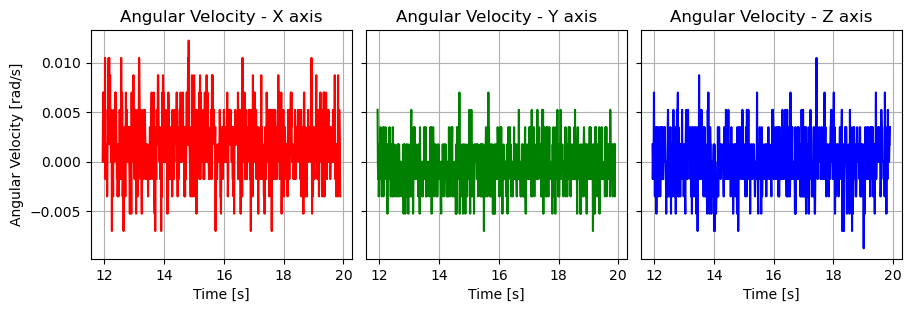

In [214]:
gyro_pre_take_off_segment = get_segment_index_from_ts_segments(gyro_df, [[baro_df['timestamp_sample'][250], baro_df['timestamp_sample'][i-100]]])[0]
print(gyro_pre_take_off_segment)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
# Plot X axis
axes[0].plot(gyro_flight_seconds[gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]],
             gyro_df['x'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]], color='r')
axes[0].set_title("Angular Velocity - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Angular Velocity [rad/s]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(gyro_flight_seconds[gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]],
             gyro_df['y'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]], color='g')
axes[1].set_title("Angular Velocity - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(gyro_flight_seconds[gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]],
             gyro_df['z'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]], color='b')
axes[2].set_title("Angular Velocity - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_gyro_raw.eps', format='eps', bbox_inches='tight')
print("gyro raw std!", np.std(gyro_df['x'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]]),
      np.std(gyro_df['y'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]]),
      np.std(gyro_df['z'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]]))

[836, 1632]


/tmp/ipykernel_114202/1091658052.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3)


acc raw std! 0.0806395010997663 0.10873122160674654 0.039597247405353496


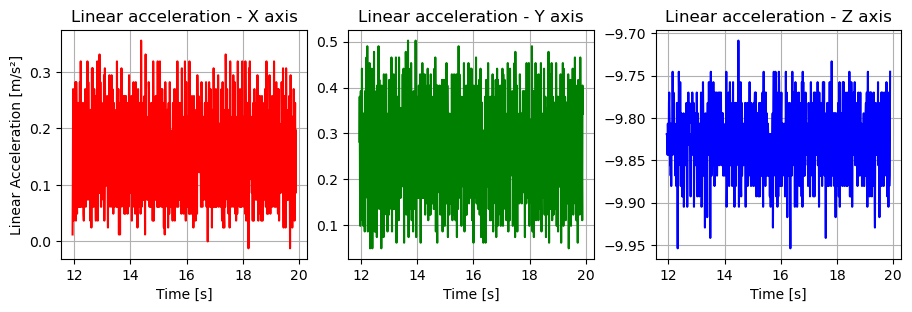

In [215]:
acc_pre_take_off_segment = get_segment_index_from_ts_segments(acc_df, [[baro_df['timestamp_sample'][250], baro_df['timestamp_sample'][i-100]]])[0]
print(acc_pre_take_off_segment)

# fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, constrained_layout=True)
plt.subplots_adjust(wspace=0.3)
# Plot X axis
axes[0].plot(acc_flight_seconds[acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]],
             acc_df['x'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]], color='r')
axes[0].set_title("Linear acceleration - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Linear Acceleration [m/s²]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(acc_flight_seconds[acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]],
             acc_df['y'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]], color='g')
axes[1].set_title("Linear acceleration - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(acc_flight_seconds[acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]],
             acc_df['z'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]], color='b')
axes[2].set_title("Linear acceleration - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_acc_raw.eps', format='eps', bbox_inches='tight')
print("acc raw std!", np.std(acc_df['x'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]),
      np.std(acc_df['y'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]),
      np.std(acc_df['z'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]))

[834, 1630]
sensor combined gyro raw std! 0.001458846 0.0006127165 0.0006508682
[834, 1630]


/tmp/ipykernel_114202/882396592.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3)


sensor combined acc raw std! 0.0076936213 0.012746436 0.006405984


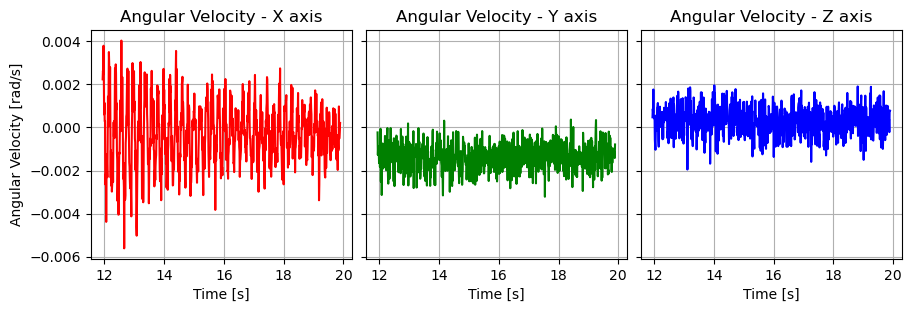

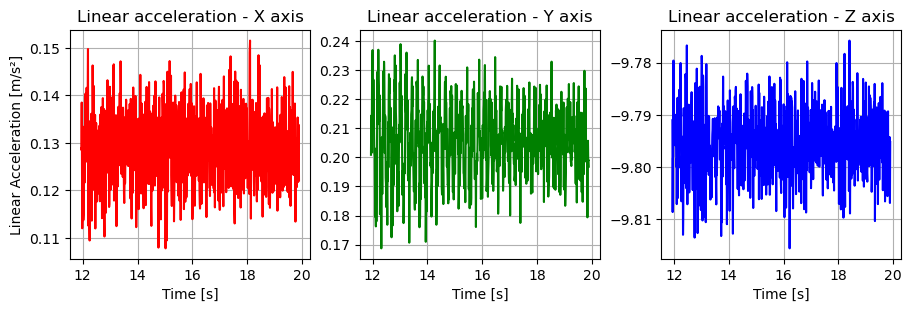

In [216]:
sc_pre_take_off_segment = get_segment_index_from_ts_segments(sc_df, [[baro_df['timestamp_sample'][250], baro_df['timestamp_sample'][i-100]]])[0]
print(sc_pre_take_off_segment)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
# Plot X axis
axes[0].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['gyro_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='r')
axes[0].set_title("Angular Velocity - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Angular Velocity [rad/s]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['gyro_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='g')
axes[1].set_title("Angular Velocity - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['gyro_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='b')
axes[2].set_title("Angular Velocity - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_sc_gyro.eps', format='eps', bbox_inches='tight')
print("sensor combined gyro raw std!", np.std(sc_df['gyro_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
      np.std(sc_df['gyro_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
      np.std(sc_df['gyro_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]))

sc_pre_take_off_segment = get_segment_index_from_ts_segments(sc_df, [[baro_df['timestamp_sample'][250], baro_df['timestamp_sample'][i-100]]])[0]
print(sc_pre_take_off_segment)

# fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, constrained_layout=True)
plt.subplots_adjust(wspace=0.3)
# Plot X axis
axes[0].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['acc_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='r')
axes[0].set_title("Linear acceleration - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Linear Acceleration [m/s²]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['acc_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='g')
axes[1].set_title("Linear acceleration - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['acc_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='b')
axes[2].set_title("Linear acceleration - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_sc_acc.eps', format='eps', bbox_inches='tight')
print("sensor combined acc raw std!", np.std(sc_df['acc_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
      np.std(sc_df['acc_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
      np.std(sc_df['acc_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]))

[357, 664]
imu gyro raw std! 0.002081213863403286 0.001988189468928814 0.0014097274908193456
[357, 664]


/tmp/ipykernel_114202/4215569361.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3)


imu acc raw std! 0.011586937792038806 0.017634518529854305 0.016493796613905456


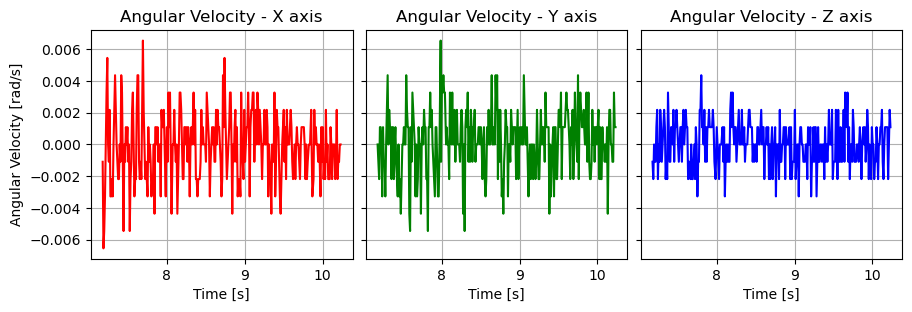

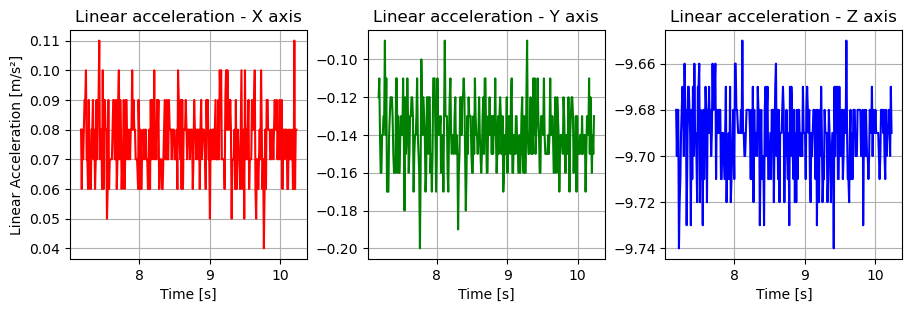

In [217]:
imu_pre_take_off_segment = get_segment_index_from_ts_segments(imu_df, [[baro_df['timestamp_sample'][250], baro_df['timestamp_sample'][i-100]]])[0]
print(imu_pre_take_off_segment)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
# Plot X axis
axes[0].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['gyro_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='r')
axes[0].set_title("Angular Velocity - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Angular Velocity [rad/s]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['gyro_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='g')
axes[1].set_title("Angular Velocity - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['gyro_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='b')
axes[2].set_title("Angular Velocity - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_imu_gyro.eps', format='eps', bbox_inches='tight')
print("imu gyro raw std!", np.std(imu_df['gyro_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
      np.std(imu_df['gyro_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
      np.std(imu_df['gyro_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]))

imu_pre_take_off_segment = get_segment_index_from_ts_segments(imu_df, [[baro_df['timestamp_sample'][250], baro_df['timestamp_sample'][i-100]]])[0]
print(imu_pre_take_off_segment)

# fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, constrained_layout=True)
plt.subplots_adjust(wspace=0.3)
# Plot X axis
axes[0].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['acc_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='r')
axes[0].set_title("Linear acceleration - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Linear Acceleration [m/s²]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['acc_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='g')
axes[1].set_title("Linear acceleration - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['acc_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='b')
axes[2].set_title("Linear acceleration - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_imu_acc.eps', format='eps', bbox_inches='tight')
print("imu acc raw std!", np.std(imu_df['acc_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
      np.std(imu_df['acc_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
      np.std(imu_df['acc_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]))

# Another point selected at random

In [218]:
point = 2

[23159, 24318]
gyro raw std! 0.06903039100902146 0.04090128350453765 0.13296473826989183


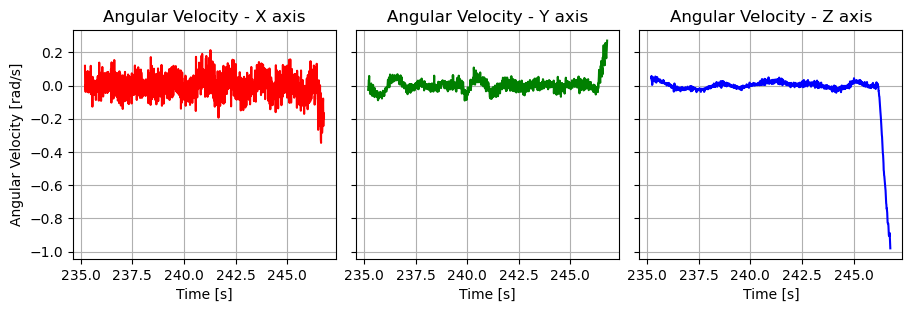

In [219]:
gyro_pre_take_off_segment = gyro_segments[point]
print(gyro_pre_take_off_segment)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
# Plot X axis
axes[0].plot(gyro_flight_seconds[gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]],
             gyro_df['x'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]], color='r')
axes[0].set_title("Angular Velocity - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Angular Velocity [rad/s]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(gyro_flight_seconds[gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]],
             gyro_df['y'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]], color='g')
axes[1].set_title("Angular Velocity - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(gyro_flight_seconds[gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]],
             gyro_df['z'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]], color='b')
axes[2].set_title("Angular Velocity - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_gyro_raw_air.eps', format='eps', bbox_inches='tight')
print("gyro raw std!", np.std(gyro_df['x'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]]),
      np.std(gyro_df['y'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]]),
      np.std(gyro_df['z'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]]))

[23162, 24321]


/tmp/ipykernel_114202/2626440706.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3)


acc raw std! 0.977806999851309 2.758897641213787 3.7270335215986226


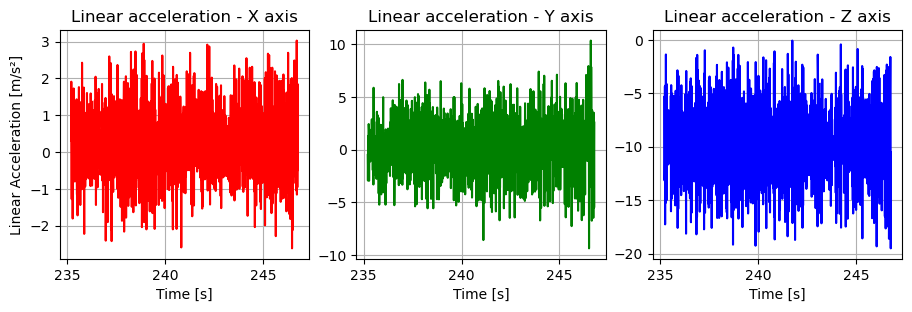

In [220]:
acc_pre_take_off_segment = acc_segments[point]
print(acc_pre_take_off_segment)

# fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, constrained_layout=True)
plt.subplots_adjust(wspace=0.3)
# Plot X axis
axes[0].plot(acc_flight_seconds[acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]],
             acc_df['x'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]], color='r')
axes[0].set_title("Linear acceleration - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Linear Acceleration [m/s²]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(acc_flight_seconds[acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]],
             acc_df['y'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]], color='g')
axes[1].set_title("Linear acceleration - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(acc_flight_seconds[acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]],
             acc_df['z'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]], color='b')
axes[2].set_title("Linear acceleration - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_acc_raw_air.eps', format='eps', bbox_inches='tight')
print("acc raw std!", np.std(acc_df['x'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]),
      np.std(acc_df['y'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]),
      np.std(acc_df['z'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]))

[23160, 24319]
sensor combined gyro raw std! 0.042794716 0.037797965 0.13236538


/tmp/ipykernel_114202/1849757254.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3)


sensor combined acc raw std! 0.14226744 0.3274036 0.28097466


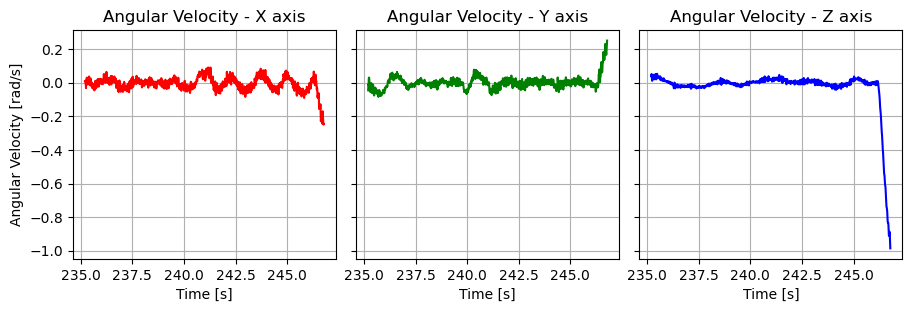

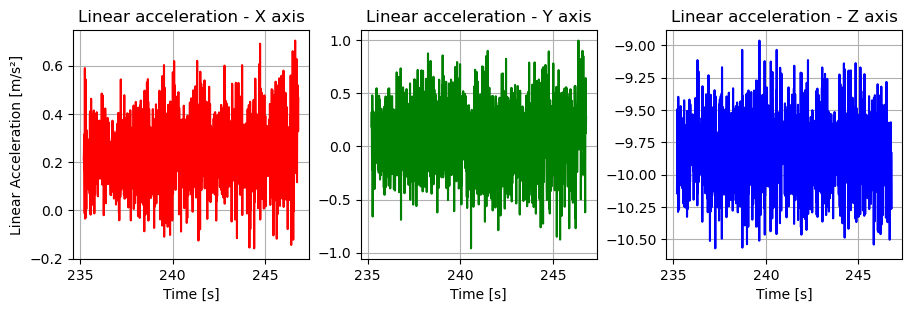

In [221]:
sc_pre_take_off_segment = sc_segments[point]
print(sc_pre_take_off_segment)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
# Plot X axis
axes[0].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['gyro_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='r')
axes[0].set_title("Angular Velocity - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Angular Velocity [rad/s]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['gyro_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='g')
axes[1].set_title("Angular Velocity - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['gyro_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='b')
axes[2].set_title("Angular Velocity - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_sc_gyro_air.eps', format='eps', bbox_inches='tight')
print("sensor combined gyro raw std!", np.std(sc_df['gyro_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
      np.std(sc_df['gyro_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
      np.std(sc_df['gyro_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]))

# sc_pre_take_off_segment = get_segment_index_from_ts_segments(sc_df, [[baro_df['timestamp_sample'][250], baro_df['timestamp_sample'][i-100]]])[0]
# print(sc_pre_take_off_segment)

# fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, constrained_layout=True)
plt.subplots_adjust(wspace=0.3)
# Plot X axis
axes[0].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['acc_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='r')
axes[0].set_title("Linear acceleration - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Linear Acceleration [m/s²]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['acc_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='g')
axes[1].set_title("Linear acceleration - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(sc_flight_seconds[sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]],
             sc_df['acc_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]], color='b')
axes[2].set_title("Linear acceleration - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_sc_acc_air.eps', format='eps', bbox_inches='tight')
print("sensor combined acc raw std!", np.std(sc_df['acc_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
      np.std(sc_df['acc_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
      np.std(sc_df['acc_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]))

[9097, 9565]
imu gyro raw std! 0.04275304943611798 0.03427954176860333 0.13025492152788104
[357, 664]


/tmp/ipykernel_114202/209480587.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.3)


imu acc raw std! 0.011586937792038806 0.017634518529854305 0.016493796613905456


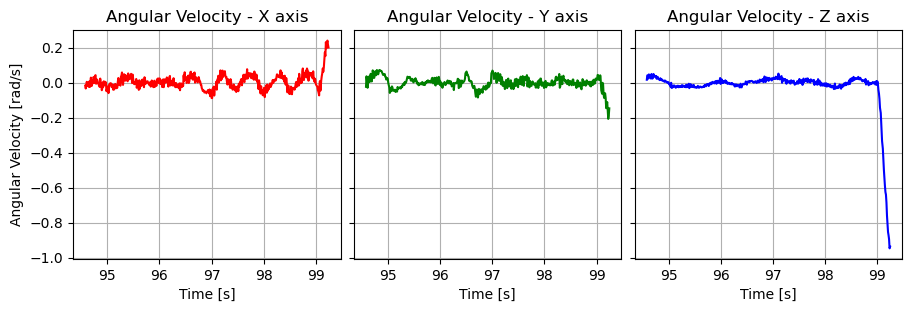

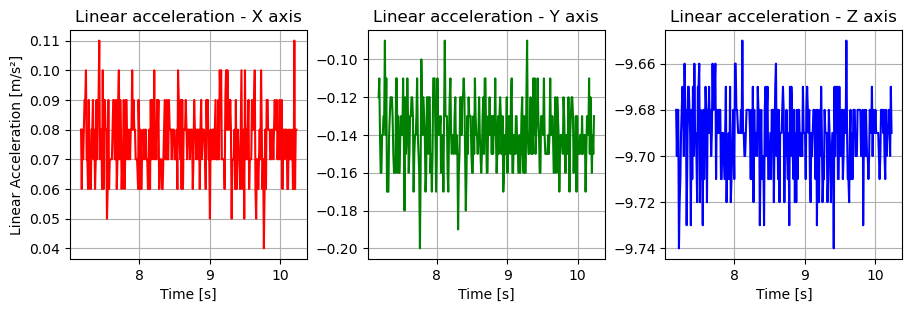

In [222]:
imu_pre_take_off_segment = imu_segments[point]
print(imu_pre_take_off_segment)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
# Plot X axis
axes[0].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['gyro_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='r')
axes[0].set_title("Angular Velocity - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Angular Velocity [rad/s]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['gyro_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='g')
axes[1].set_title("Angular Velocity - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['gyro_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='b')
axes[2].set_title("Angular Velocity - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_imu_gyro_air.eps', format='eps', bbox_inches='tight')
print("imu gyro raw std!", np.std(imu_df['gyro_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
      np.std(imu_df['gyro_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
      np.std(imu_df['gyro_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]))

imu_pre_take_off_segment = get_segment_index_from_ts_segments(imu_df, [[baro_df['timestamp_sample'][250], baro_df['timestamp_sample'][i-100]]])[0]
print(imu_pre_take_off_segment)

# fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True, constrained_layout=True)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, constrained_layout=True)
plt.subplots_adjust(wspace=0.3)
# Plot X axis
axes[0].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['acc_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='r')
axes[0].set_title("Linear acceleration - X axis")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Linear Acceleration [m/s²]")
axes[0].grid(True)

# Plot Y axis
axes[1].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['acc_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='g')
axes[1].set_title("Linear acceleration - Y axis")
axes[1].set_xlabel("Time [s]")
axes[1].grid(True)

# Plot Z axis
axes[2].plot(imu_flight_seconds[imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]],
             imu_df['acc_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]], color='b')
axes[2].set_title("Linear acceleration - Z axis")
axes[2].set_xlabel("Time [s]")
axes[2].grid(True)
plt.savefig('figures/'+name+'_imu_acc_air.eps', format='eps', bbox_inches='tight')
print("imu acc raw std!", np.std(imu_df['acc_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
      np.std(imu_df['acc_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
      np.std(imu_df['acc_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]))

In [223]:
import csv
csv_file_name = 'csv/imus_'+name+'_'+str(point)+'.csv'

fieldnames = ['scenario', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({'scenario':'raw',
                        'acc_x':np.std(acc_df['x'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]),
                        'acc_y':np.std(acc_df['y'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]), 
                        'acc_z':np.std(acc_df['z'][acc_pre_take_off_segment[0]:acc_pre_take_off_segment[1]]), 
                        'gyro_x':np.std(gyro_df['x'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]]),
                        'gyro_y':np.std(gyro_df['y'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]]), 
                        'gyro_z':np.std(gyro_df['z'][gyro_pre_take_off_segment[0]:gyro_pre_take_off_segment[1]])
                        })
    writer.writerow({'scenario':'combined',
                        'acc_x':np.std(sc_df['acc_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
                        'acc_y':np.std(sc_df['acc_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]), 
                        'acc_z':np.std(sc_df['acc_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]), 
                        'gyro_x':np.std(sc_df['gyro_x'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]),
                        'gyro_y':np.std(sc_df['gyro_y'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]]), 
                        'gyro_z':np.std(sc_df['gyro_z'][sc_pre_take_off_segment[0]:sc_pre_take_off_segment[1]])
                        })
    writer.writerow({'scenario':'bosch',
                        'acc_x':np.std(imu_df['acc_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
                        'acc_y':np.std(imu_df['acc_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]), 
                        'acc_z':np.std(imu_df['acc_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]), 
                        'gyro_x':np.std(imu_df['gyro_x'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]),
                        'gyro_y':np.std(imu_df['gyro_y'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]]), 
                        'gyro_z':np.std(imu_df['gyro_z'][imu_pre_take_off_segment[0]:imu_pre_take_off_segment[1]])
                        })